In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RL.csv'
fr = pd.read_csv(FILE)

V = np.array(fr['VR (mV)'])* 10**-3
t = np.array(fr['t(us)']) * 10**-6

R = 996 # misurata con multimetro
R_L = 58.5 # resistenza interna all'induttanza misurata dal multimetro

sigmaR = 1 # ohm
sigmaR_L = 0.1 # ohm

T = 0.05 # s impostato sull'oscilloscopio, valutare se rimuovere
sigmaV = 0.2 /np.sqrt(12)

$
V_R(t) = V_g \left(1 - \frac{2 \cdot e^{-\frac{t}{\tau}}}{1 + e^{-\frac{T}{2\tau}}}\right) 
$

where $\tau = \frac{L}{R}$

In [27]:
def VR(t,τ,Vg):
    return Vg*(1- 2*np.exp(-t/τ)/(1+np.exp(-T/(2*τ))))

L_guess = 0.082 # Hr
Vg_guess = 1.984 # V
iVR = Interpolazione(t,V,VR,sigmaV,p0=[L_guess/R,Vg_guess])
print(iVR)

# dala tensione misurata su VR calcoliamo la corrente passante nell'induttanza
It = iVR.y_best/R # V = RI, calcolo corrente passante nel circuito (e quindi anche nell'induttanza)

print('----------------------- RESULT -----------------------')

τ = iVR.bval[0]
sigmaτ = iVR.sigma_bval[0]

VgVL = iVR.bval[1]
sigmaVgVL = iVR.sigma_bval[1]

L = τ*R
sigmaL = np.sqrt((R*sigmaτ)**2 + (τ*sigmaR)**2)

# Calcolo tensione in R_L: I(t) = V_L/R_L*(exp...) -> V_L = I(t)*R_L in particolare in t = 0:
V_L = VgVL/R * R_L
sigmaVL = np.sqrt((VgVL/R * sigmaR_L)**2 + (VgVL/R * R_L/R * sigmaVgVL)**2) # TODO: verificare formula

Vg = V_L + VgVL
sigmaVg = np.sqrt(sigmaVL**2 + sigmaVgVL**2)

print('L =',final_val(L,sigmaL,decimals=1,exp=-3,udm='Hr')) # TODO: valutare numero di decimali significativi
print('V_g - V_L = ',final_val(VgVL,sigmaVgVL,decimals=3,udm='V')) # misurata sperimentale
print('V_L = ',final_val(V_L,sigmaVL,decimals=3,udm='V'))
print('Vg = ', final_val(Vg,sigmaVg,decimals=3,udm='V'))

   
Parameters: [8.42516516e-05 1.81763556e+00] 
Sigma parameters: [2.80459959e-07 4.64093692e-03]

sigmaY: 0.05773502691896258

chiquadro ridotto: 0.12
df: 53
pvalue: 100.0%
covariance matrix: [[7.30412322e-14 4.93304787e-10]
 [4.93304787e-10 2.00003544e-05]]    

----------------------- RESULT -----------------------
L = (83.9 ± 0.3)e-3 Hr
V_g - V_L =  1.818 ± 0.005 V
V_L =  0.107 ± 0.0 V
Vg =  1.924 ± 0.005 V


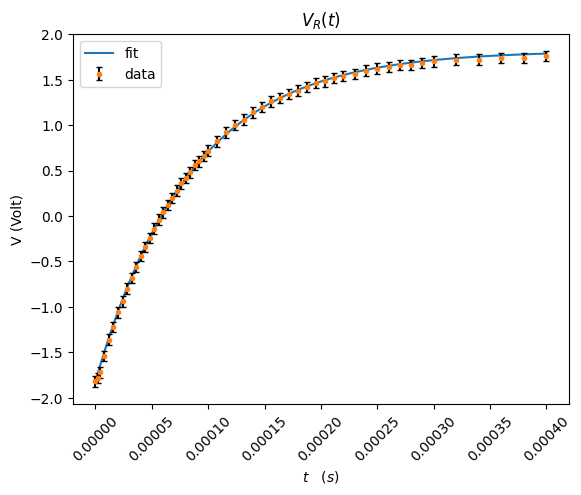

In [22]:
plt.plot(iVR.x_best, iVR.y_best, label='fit')
plt.errorbar(t, V, yerr=sigmaV, ecolor='black', fmt='.', label='data',capsize=2)
plt.xlabel('$t \quad (s)$')
plt.ylabel('V (Volt)')
plt.legend()
plt.title('$V_R(t)$')
plt.xticks(rotation=45)
plt.show()

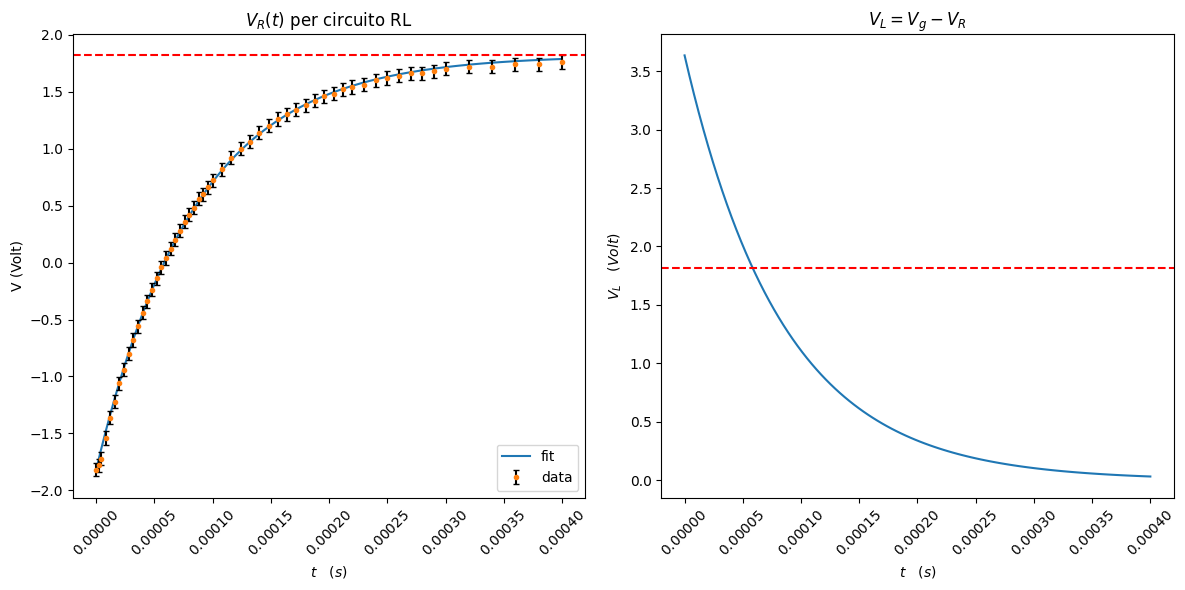

In [20]:
from matplotlib import ticker
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot on the left subplot
ax1.plot(i.x_best, i.y_best, label='fit')
ax1.errorbar(t, V, yerr=sigmaV, ecolor='black', fmt='.', label='data',capsize=2)
ax1.set_xlabel('$t \quad (s)$')
ax1.set_ylabel('V (Volt)')
# Set the x-axis labels in exponential format
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.xaxis.offsetText.set_visible(False)
# Set the x-axis labels rotation
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.set_title('$V_R(t)$ per circuito RL')
ax1.axhline(Vg, color='red', linestyle='--', label='Vg')


# Plot on the right subplot
V_L = Vg - i.y_best
ax2.plot(i.x_best, V_L)
ax2.set_xlabel('$t \quad (s)$')
ax2.set_ylabel('$V_L \quad (Volt)$')
ax2.set_title('$V_L = V_g - V_R$') # TODO:  - V_{R_L}
# Set the x-axis labels in exponential format
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax2.xaxis.offsetText.set_visible(False)
# Set the x-axis labels rotation
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(Vg, color='red', linestyle='--', label='Vg')

plt.tight_layout()
plt.show()